# Importing the libraries

In [1]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os

In [ ]:
!unrar x /content/EmotionDataset.rar

## Data Preparation

The dataset contain 35,685 examples of 48x48 pixel gray scale images of faces divided into train and test.

In [2]:
train_path = r'EmotionDataset/train'
test_path = r'EmotionDataset/test'

In [3]:
target_labels = os.listdir(train_path) #getting our classes' names
"""
This returns the list of all files in the specified path. The return type is list.
"""
target_labels

['fearful', 'angry', 'sad', 'surprised', 'neutral', 'disgusted', 'happy']

we have 7 different emotions

## Data Visualization

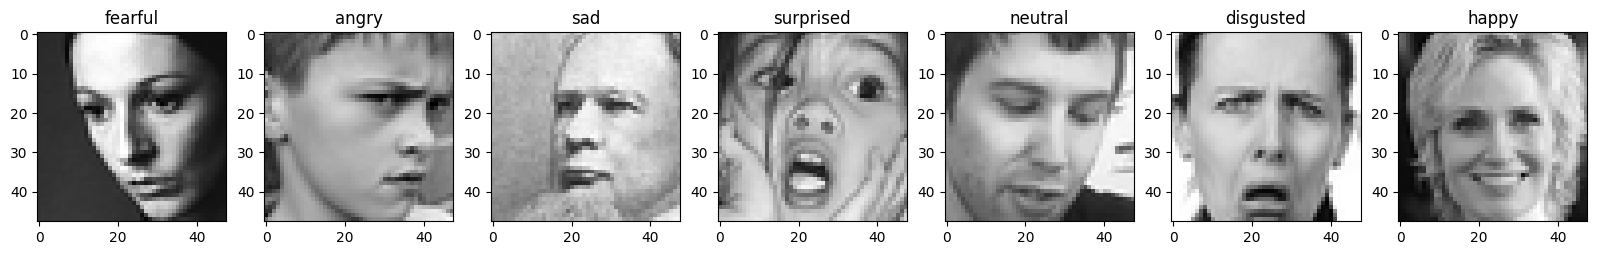

In [4]:
fig, axes = plt.subplots(1, 7, figsize = (20, 10))

for i in range(len(target_labels)):
  tt = cv2.imread(train_path+'/'+target_labels[i]+'/'+os.listdir(train_path+'/'+target_labels[i]+'/')[0]) #reading the first image in each class to display it
  axes[i].imshow(tt) #displaying the sample images
  axes[i].set_title(target_labels[i]) #labelling each image with its emotion that is provided in our train data

## EDA

Exploring the distribution of our classes (how many images in each one)

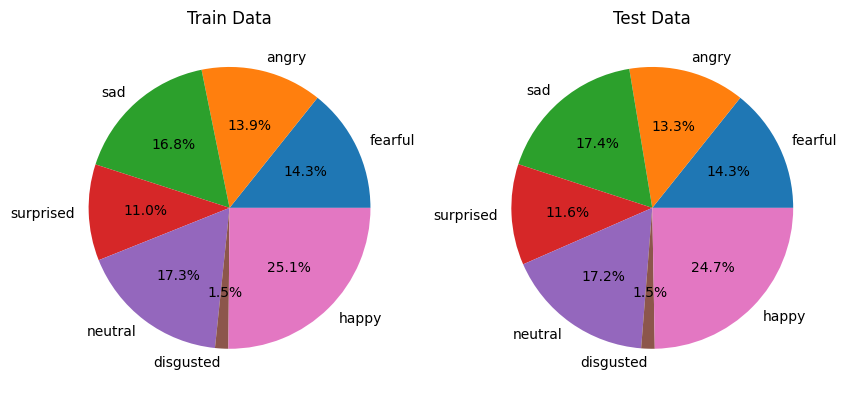

In [5]:
train_len = np.array([ len(os.listdir(train_path + '/' + label + '/')) for label in target_labels ])
test_len = np.array([ len(os.listdir(test_path + '/' + label + '/')) for label in target_labels ])

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].pie(train_len, labels = target_labels, autopct='%1.1f%%',)
axes[0].set_title('Train Data')
axes[1].pie(test_len, labels = target_labels, autopct='%1.1f%%',)
axes[1].set_title('Test Data')
plt.show()

there is somehow nearly fair distribution between the classes expect "disgusted" having the least number of images

## Data Augmentation using Data Generator

In [6]:
from keras.preprocessing.image import ImageDataGenerator

#train data
train_gen = ImageDataGenerator(rescale = 1./255,
                               validation_split=.2,
                               )

#validation data that's taken from our train data --> to improve the model's performance
validation_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)


#test data
test_datagen = ImageDataGenerator(rescale = 1./255)


train_batch = train_gen.flow_from_directory(directory = train_path,
                                            target_size = (48, 48),
                                            batch_size = 64,
                                            color_mode = 'grayscale',
                                            subset = 'training',
                                            class_mode = 'categorical',
                                            seed = 42
                                            )

val_batch = validation_datagen.flow_from_directory(directory = train_path,
                                            target_size = (48, 48),
                                            batch_size = 64,
                                            color_mode = 'grayscale',
                                            subset = 'validation',
                                            class_mode = 'categorical',
                                            seed = 42
                                            )


test_batch = test_datagen.flow_from_directory(directory = test_path,
                                            target_size = (48, 48),
                                            batch_size = 64,
                                            class_mode = 'categorical',
                                            color_mode = 'grayscale',
                                            seed = 42
                                            )

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


## Building The Models

### AlexNet Model

In [7]:
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras import Sequential

In [37]:
#AlexNet Architecture
AlexNetmodel = tf.keras.models.Sequential([
    # 1st conv
  tf.keras.layers.Conv2D(96, (11,11), strides=(4,4), activation='relu', input_shape=(48, 48, 1)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, strides=(2,2)),
    # 2nd conv
  tf.keras.layers.Conv2D(256, (5,5), strides=(1,1), activation='relu', padding="same"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, strides=(2,2)),
     # 3rd conv
  tf.keras.layers.Conv2D(384, (3,3), strides=(1,1), activation='relu', padding="same"),
  tf.keras.layers.BatchNormalization(),
    # 4th conv
  tf.keras.layers.Conv2D(384, (3,3), strides=(1,1), activation='relu', padding="same"),
  tf.keras.layers.BatchNormalization(),
    # 5th Conv
  tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding="same"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, strides=(2, 2)),
  # Flatten layer
  tf.keras.layers.Flatten(),
  # FC layer 1
  tf.keras.layers.Dense(4096, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.4),
  # FC layer 2
  tf.keras.layers.Dense(4096, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.4),
  # FC layer 3
  tf.keras.layers.Dense(1000, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.4),

  tf.keras.layers.Dense(7, activation='softmax')
])

In [38]:
AlexNetmodel.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 10, 10, 96)        11712     
                                                                 
 batch_normalization_16 (Bat  (None, 10, 10, 96)       384       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 5, 5, 96)         0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 5, 5, 256)         614656    
                                                                 
 batch_normalization_17 (Bat  (None, 5, 5, 256)        1024      
 chNormalization)                                                
                                                      

### Model 1

In [8]:
#Building our CNN

model1 = Sequential()

model1.add(Conv2D(64, (3, 3), padding = 'same', input_shape = (48, 48, 1)))
model1.add(Activation ('relu'))
model1.add(MaxPooling2D(pool_size = (2, 2)))
model1.add(BatchNormalization())
model1.add(Dropout(0.3))

model1.add(Conv2D(128, (5, 5), padding = 'same', input_shape = (48, 48, 1)))
model1.add(Activation ('relu'))
model1.add(MaxPooling2D(pool_size = (2, 2)))
model1.add(BatchNormalization())
model1.add(Dropout(0.3))


model1.add(Conv2D(256, (3, 3), padding = 'same', input_shape = (48, 48, 1)))
model1.add(Activation ('relu'))
model1.add(MaxPooling2D(pool_size = (2, 2)))
model1.add(BatchNormalization())
model1.add(Dropout(0.3))

model1.add(Conv2D(512, (5, 5), padding = 'same', input_shape = (48, 48, 1)))
model1.add(Activation ('relu'))
model1.add(MaxPooling2D(pool_size = (2, 2)))
model1.add(BatchNormalization())
model1.add(Dropout(0.3))

model1.add(Flatten())
model1.add(Dense(64))
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.5))


model1.add(Dense(64))
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.5))


model1.add(Dense(7))
model1.add(Activation('softmax'))

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 24, 24, 64)       256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

### Transfer Learning (Model 2)

In [ ]:
from keras.applications import VGG19
conv_base = VGG19(weights='imagenet',
                 include_top=False,
                 input_shape=(48, 48, 3))
model2 = Sequential()
# for layer in vgg19_model.layers[:-1]:
#     model2.add(layer)
model2.add(conv_base)
for layer in model2.layers:
  layer.trainable = False #freezing the layers

model2.add(Flatten())
model2.add(Dense(256, activation='relu'))
model2.add(Dense(7, activation='softmax'))


In [ ]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 20,157,511
Trainable params: 133,127
Non-trainable params: 20,024,384
_________________________________________________________________


### Model 3

In [ ]:
model3 = Sequential()

#decreasing number of blocks but increasing the nnumber of convolutional layers more than Model 1 gave us better accuracy, and also making filter size 3X3
#also changing the activation function to elu instead of relu
model3.add(Conv2D(64, (3,3), padding='same', kernel_initializer='he_normal', input_shape = (48, 48, 1)))
model3.add(Activation ('elu'))
model3.add(BatchNormalization())
model3.add(Conv2D(64, (3,3), padding='same', kernel_initializer='he_normal', input_shape=(48, 48, 1)))
model3.add(Activation ('elu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size = (2, 2)))
model3.add(Dropout(0.35))

model3.add(Conv2D(128, (3, 3), padding = 'same', kernel_initializer='he_normal', input_shape = (48, 48, 1)))
model3.add(Activation ('elu'))
model3.add(BatchNormalization())
model3.add(Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal', input_shape=(48, 48, 1)))
model3.add(Activation ('elu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size = (2, 2)))
model3.add(Dropout(0.4))


model3.add(Conv2D(256, (3, 3), padding = 'same', kernel_initializer='he_normal', input_shape = (48, 48, 1)))
model3.add(Activation ('elu'))
model3.add(BatchNormalization())
model3.add(Conv2D(256, (3, 3), padding = 'same', kernel_initializer='he_normal', input_shape = (48, 48, 1)))
model3.add(Activation ('elu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size = (2, 2)))
model3.add(Dropout(0.5))

model3.add(Flatten())
model3.add(Dense(256))
model3.add(Activation('elu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.5))

model3.add(Dense(7))
model3.add(Activation('softmax'))

In [ ]:
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 activation_1 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                        

### Model 4

In [34]:
model4 = tf.keras.Sequential()
#more increasing in convolutional layers and activation function is now relu, decreasing the dropout rate
model4.add(Conv2D(32,(3,3),padding='same',kernel_initializer='he_normal',input_shape=(48,48,1)))
model4.add(Activation('relu'))
model4.add(BatchNormalization())
model4.add(Conv2D(32,(3,3),padding='same',kernel_initializer='he_normal',input_shape=(48,48,1)))
model4.add(Activation('relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2,2)))
model4.add(Dropout(0.2))


model4.add(Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal'))
model4.add(Activation('relu'))
model4.add(BatchNormalization())
model4.add(Conv2D(64,(3,3),padding='same',kernel_initializer='he_normal'))
model4.add(Activation('relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2,2)))
model4.add(Dropout(0.2))


model4.add(Conv2D(128,(3,3),padding='same',kernel_initializer='he_normal'))
model4.add(Activation('relu'))
model4.add(BatchNormalization())
model4.add(Conv2D(128,(3,3),padding='same',kernel_initializer='he_normal'))
model4.add(Activation('relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2,2)))
model4.add(Dropout(0.2))


model4.add(Conv2D(256,(3,3),padding='same',kernel_initializer='he_normal'))
model4.add(Activation('relu'))
model4.add(BatchNormalization())
model4.add(Conv2D(256,(3,3),padding='same',kernel_initializer='he_normal'))
model4.add(Activation('relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2,2)))
model4.add(Dropout(0.2))


model4.add(Flatten())
model4.add(Dense(64,kernel_initializer='he_normal'))
model4.add(Activation('relu'))
model4.add(BatchNormalization())
model4.add(Dropout(0.5))


model4.add(Dense(64,kernel_initializer='he_normal'))
model4.add(Activation('relu'))
model4.add(BatchNormalization())
model4.add(Dropout(0.5))


model4.add(Dense(7,kernel_initializer='he_normal'))
model4.add(Activation('softmax'))

In [35]:
model4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 activation_7 (Activation)   (None, 48, 48, 32)        0         
                                                                 
 batch_normalization_6 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 activation_8 (Activation)   (None, 48, 48, 32)        0         
                                                                 
 batch_normalization_7 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                      

## Training The Models

### Model Checkpoint and Early Stopping

In [9]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='val_accuracy',
                   min_delta= 0.01, #minimum change
                   patience= 20,
                   verbose= 1,
                   mode='auto')

mc = ModelCheckpoint(filepath='best_model.h5',
                     monitor= 'val_accuracy',
                     verbose= 1,
                     save_best_only= True,
                     mode = 'max')

callback_list1 = [es, mc]

In [26]:
es2 = EarlyStopping(monitor='val_accuracy',
                   min_delta= 0.01, #minimum change
                   patience= 15,
                   verbose= 1,
                   mode='auto')

mc2 = ModelCheckpoint(filepath='best_model4.h5',
                     monitor= 'val_accuracy',
                     verbose= 1,
                     save_best_only= True,
                     mode = 'max')

callback_list2 = [es2, mc2]

In [29]:
es3 = EarlyStopping(monitor='val_accuracy',
                   min_delta= 0.01, #minimum change
                   patience= 25,
                   verbose= 1,
                   mode='auto')

mc3 = ModelCheckpoint(filepath='best_model5.h5',
                     monitor= 'val_accuracy',
                     verbose= 1,
                     save_best_only= True,
                     mode = 'max')

callback_list3 = [es3, mc3]

In [36]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

es4 = EarlyStopping(monitor='val_accuracy',
                   min_delta= 0.01, #minimum change
                   patience= 20,
                   verbose= 1,
                   mode='auto')

mc4 = ModelCheckpoint(filepath='best_model6.h5',
                     monitor= 'val_accuracy',
                     verbose= 1,
                     save_best_only= True,
                     mode = 'max')

callback_list4 = [es4, mc4]

### Compiling & Fitting

In [14]:
AlexNetmodel.compile(loss='categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005),
                metrics=['accuracy'])
history_ = AlexNetmodel.fit(train_batch ,
                      validation_data = val_batch,
                      batch_size = 16,
                      epochs = 100
                      )

Epoch 1/100
359/359 [==============================] - 44s 72ms/step - loss: 2.3044 - accuracy: 0.2066 - val_loss: 1.9390 - val_accuracy: 0.2513
Epoch 2/100
359/359 [==============================] - 25s 68ms/step - loss: 1.9860 - accuracy: 0.2478 - val_loss: 1.9261 - val_accuracy: 0.2315
Epoch 3/100
359/359 [==============================] - 26s 73ms/step - loss: 1.9125 - accuracy: 0.2635 - val_loss: 1.9208 - val_accuracy: 0.2414
Epoch 4/100
359/359 [==============================] - 24s 68ms/step - loss: 1.8840 - accuracy: 0.2761 - val_loss: 1.7781 - val_accuracy: 0.3040
Epoch 5/100
359/359 [==============================] - 24s 67ms/step - loss: 1.8422 - accuracy: 0.2867 - val_loss: 2.1986 - val_accuracy: 0.1864
Epoch 6/100
359/359 [==============================] - 24s 68ms/step - loss: 1.8057 - accuracy: 0.2963 - val_loss: 1.9000 - val_accuracy: 0.2837
Epoch 7/100
359/359 [==============================] - 24s 67ms/step - loss: 1.7776 - accuracy: 0.3055 - val_loss: 1.7718 - val_ac

AlexNet model has v bad accuracy so we will not continue with it

In [ ]:
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

history1 = model1.fit(train_batch ,
                      validation_data = val_batch,
                      batch_size = 10,
                      epochs = 150,
                      callbacks = callback_list1)

Using rgb color mode to use the VGG19 pretrained model

In [24]:
train_batch1 = train_gen.flow_from_directory(directory = train_path,
                                            target_size = (48, 48),
                                            batch_size = 64,
                                            color_mode = 'rgb',
                                            subset = 'training',
                                            class_mode = 'categorical',
                                            seed = 42
                                            )

val_batch1 = validation_datagen.flow_from_directory(directory = train_path,
                                                    target_size = (48, 48),
                                                    batch_size = 64,
                                                    color_mode = 'rgb',
                                                    subset = 'validation',
                                                    class_mode = 'categorical',
                                                    seed = 42)

test_batch1 = test_datagen.flow_from_directory(directory = test_path,
                                              target_size = (48, 48),
                                              batch_size = 64,
                                              class_mode = 'categorical',
                                              color_mode = 'rgb',
                                              seed = 42
                                              )

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
model2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
               loss='categorical_crossentropy',
               metrics=['accuracy'] )

history2 = model2.fit(train_batch1 ,
                      validation_data = val_batch1,
                      batch_size = 16,
                      epochs = 150,
                      callbacks = callback_list2)

Epoch 1/150
359/359 [==============================] - ETA: 0s - loss: 1.7514 - accuracy: 0.2794
Epoch 1: val_accuracy improved from -inf to 0.29890, saving model to best_model4.h5
359/359 [==============================] - 40s 100ms/step - loss: 1.7514 - accuracy: 0.2794 - val_loss: 1.7469 - val_accuracy: 0.2989
Epoch 2/150
359/359 [==============================] - ETA: 0s - loss: 1.7145 - accuracy: 0.3058
Epoch 2: val_accuracy improved from 0.29890 to 0.33235, saving model to best_model4.h5
359/359 [==============================] - 39s 109ms/step - loss: 1.7145 - accuracy: 0.3058 - val_loss: 1.6595 - val_accuracy: 0.3323
Epoch 3/150
359/359 [==============================] - ETA: 0s - loss: 1.6948 - accuracy: 0.3158
Epoch 3: val_accuracy improved from 0.33235 to 0.35482, saving model to best_model4.h5
359/359 [==============================] - 37s 102ms/step - loss: 1.6948 - accuracy: 0.3158 - val_loss: 1.6343 - val_accuracy: 0.3548
Epoch 4/150
359/359 [============================

In [ ]:
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

history3 = model3.fit(train_batch ,
                      validation_data = val_batch,
                      batch_size = 16,
                      epochs = 150,
                      callbacks = callback_list3)

Epoch 1/150
359/359 [==============================] - ETA: 0s - loss: 2.1373 - accuracy: 0.2336
Epoch 1: val_accuracy improved from -inf to 0.32851, saving model to best_model5.h5
359/359 [==============================] - 46s 95ms/step - loss: 2.1373 - accuracy: 0.2336 - val_loss: 1.7428 - val_accuracy: 0.3285
Epoch 2/150
359/359 [==============================] - ETA: 0s - loss: 1.7777 - accuracy: 0.2951
Epoch 2: val_accuracy improved from 0.32851 to 0.37537, saving model to best_model5.h5
359/359 [==============================] - 26s 73ms/step - loss: 1.7777 - accuracy: 0.2951 - val_loss: 1.6078 - val_accuracy: 0.3754
Epoch 3/150
359/359 [==============================] - ETA: 0s - loss: 1.6765 - accuracy: 0.3373
Epoch 3: val_accuracy improved from 0.37537 to 0.41839, saving model to best_model5.h5
359/359 [==============================] - 26s 72ms/step - loss: 1.6765 - accuracy: 0.3373 - val_loss: 1.5261 - val_accuracy: 0.4184
Epoch 4/150
359/359 [==============================]

In [37]:
model4.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history4 = model4.fit(train_batch ,
                      validation_data = val_batch,
                      batch_size = 16,
                      epochs = 150,
                      callbacks = callback_list4)

Epoch 1/150
359/359 [==============================] - ETA: 0s - loss: 2.5087 - accuracy: 0.1901
Epoch 1: val_accuracy improved from -inf to 0.24508, saving model to best_model6.h5
359/359 [==============================] - 24s 44ms/step - loss: 2.5087 - accuracy: 0.1901 - val_loss: 1.9041 - val_accuracy: 0.2451
Epoch 2/150
359/359 [==============================] - ETA: 0s - loss: 2.0036 - accuracy: 0.2466
Epoch 2: val_accuracy improved from 0.24508 to 0.35029, saving model to best_model6.h5
359/359 [==============================] - 15s 41ms/step - loss: 2.0036 - accuracy: 0.2466 - val_loss: 1.6998 - val_accuracy: 0.3503
Epoch 3/150
358/359 [============================>.] - ETA: 0s - loss: 1.7334 - accuracy: 0.3331
Epoch 3: val_accuracy improved from 0.35029 to 0.39697, saving model to best_model6.h5
359/359 [==============================] - 14s 39ms/step - loss: 1.7335 - accuracy: 0.3330 - val_loss: 1.5447 - val_accuracy: 0.3970
Epoch 4/150
359/359 [==============================]

### Loading The Pre-saved Models to continue training

In [10]:
from keras.models import load_model

model1 = load_model('/content/best_model.h5')
history1 = model1.fit(train_batch,
                      validation_data = val_batch,
                      epochs = 10,
                      callbacks = callback_list1)

Epoch 1/10
359/359 [==============================] - ETA: 0s - loss: 1.0225 - accuracy: 0.6256
Epoch 1: val_accuracy improved from -inf to 0.63961, saving model to best_model.h5
359/359 [==============================] - 26s 52ms/step - loss: 1.0225 - accuracy: 0.6256 - val_loss: 0.9526 - val_accuracy: 0.6396
Epoch 2/10
359/359 [==============================] - ETA: 0s - loss: 0.9835 - accuracy: 0.6411
Epoch 2: val_accuracy improved from 0.63961 to 0.64867, saving model to best_model.h5
359/359 [==============================] - 14s 38ms/step - loss: 0.9835 - accuracy: 0.6411 - val_loss: 0.9410 - val_accuracy: 0.6487
Epoch 3/10
358/359 [============================>.] - ETA: 0s - loss: 0.9481 - accuracy: 0.6564
Epoch 3: val_accuracy did not improve from 0.64867
359/359 [==============================] - 14s 39ms/step - loss: 0.9479 - accuracy: 0.6566 - val_loss: 0.9447 - val_accuracy: 0.6445
Epoch 4/10
358/359 [============================>.] - ETA: 0s - loss: 0.9147 - accuracy: 0.67

In [ ]:
# import pickle
# with open('/trainHistory1', 'wb') as file_pi:
#     pickle.dump(history1.history, file_pi)

In [ ]:
# import pickle
# with open('/trainHistory1', "rb") as file_pi:
#     history1 = pickle.load(file_pi)

In [27]:
model2 = load_model('/content/best_model4.h5')
history2 = model2.fit(train_batch1 ,
                      validation_data=val_batch1,
                      epochs=10,
                      callbacks = callback_list2)

Epoch 1/10
358/359 [============================>.] - ETA: 0s - loss: 1.4896 - accuracy: 0.4191
Epoch 1: val_accuracy improved from -inf to 0.40289, saving model to best_model4.h5
359/359 [==============================] - 18s 45ms/step - loss: 1.4897 - accuracy: 0.4191 - val_loss: 1.5363 - val_accuracy: 0.4029
Epoch 2/10
358/359 [============================>.] - ETA: 0s - loss: 1.4536 - accuracy: 0.4364
Epoch 2: val_accuracy improved from 0.40289 to 0.41456, saving model to best_model4.h5
359/359 [==============================] - 15s 41ms/step - loss: 1.4535 - accuracy: 0.4364 - val_loss: 1.5225 - val_accuracy: 0.4146
Epoch 3/10
358/359 [============================>.] - ETA: 0s - loss: 1.4222 - accuracy: 0.4506
Epoch 3: val_accuracy improved from 0.41456 to 0.41648, saving model to best_model4.h5
359/359 [==============================] - 15s 40ms/step - loss: 1.4226 - accuracy: 0.4504 - val_loss: 1.5300 - val_accuracy: 0.4165
Epoch 4/10
359/359 [==============================] - E

In [30]:
model3 = load_model('/content/best_model5.h5')
history3 = model3.fit(train_batch ,
                      validation_data=val_batch,
                      epochs=10,
                      callbacks = callback_list3)

Epoch 1/10
358/359 [============================>.] - ETA: 0s - loss: 0.7209 - accuracy: 0.7324
Epoch 1: val_accuracy improved from -inf to 0.68612, saving model to best_model5.h5
359/359 [==============================] - 31s 70ms/step - loss: 0.7205 - accuracy: 0.7326 - val_loss: 0.8832 - val_accuracy: 0.6861
Epoch 2/10
359/359 [==============================] - ETA: 0s - loss: 0.6679 - accuracy: 0.7530
Epoch 2: val_accuracy improved from 0.68612 to 0.69570, saving model to best_model5.h5
359/359 [==============================] - 21s 58ms/step - loss: 0.6679 - accuracy: 0.7530 - val_loss: 0.8888 - val_accuracy: 0.6957
Epoch 3/10
359/359 [==============================] - ETA: 0s - loss: 0.6246 - accuracy: 0.7694
Epoch 3: val_accuracy did not improve from 0.69570
359/359 [==============================] - 21s 58ms/step - loss: 0.6246 - accuracy: 0.7694 - val_loss: 0.9148 - val_accuracy: 0.6889
Epoch 4/10
359/359 [==============================] - ETA: 0s - loss: 0.5820 - accuracy: 0.

In [ ]:
model4 = load_model('/content/best_model6.h5')
history4 = model4.fit(train_batch ,
                      validation_data=val_batch,
                      epochs=10,
                      callbacks = callback_list4)

## Testing The Models

### Accuracy vs Loss over the Epochs

In [12]:
from matplotlib.pyplot import figure

def plot_acc(history):
  fig = figure(figsize=(12, 4))
  ax = fig.add_subplot(1, 2, 1)

  ax.plot(history.history['accuracy'], label='Training Accuracy')
  ax.plot(history.history['val_accuracy'], label='Validation Accuracy')
  ax.set_title('Training vs Validation Accuracy')
  ax.set_ylabel('Accuarcy Value %')
  ax.set_xlabel('Epochs')
  ax.legend(loc="upper left")

  ax1 = fig.add_subplot(1, 2, 2)
  ax1.plot(history.history['loss'], label='Training Loss')
  ax1.plot(history.history['val_loss'], label='Validation Loss')
  ax1.set_title('Training vs Validation Loss')
  ax1.set_ylabel('Loss Value %')
  ax1.set_xlabel('Epochs')
  ax1.legend(loc="upper left")
  plt.show()

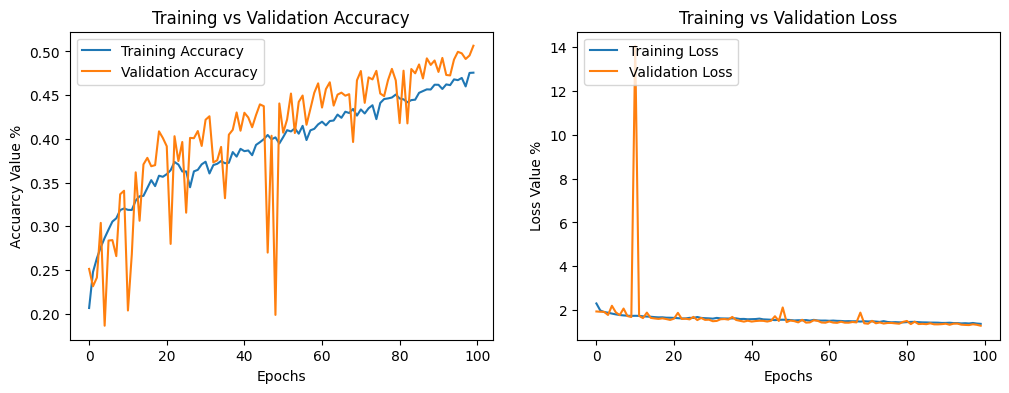

In [16]:
#the AlexNet model
plot_acc(history_)

there is too many variations and noise in the training process of AlexNet model

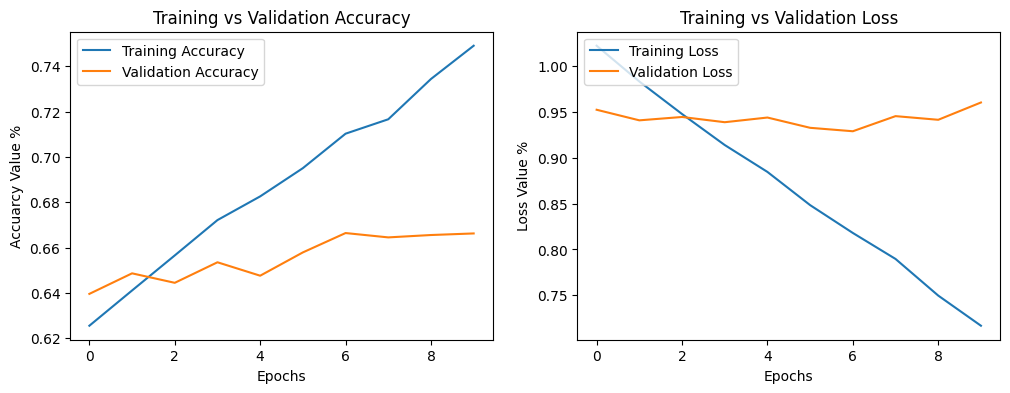

In [13]:
#Model1
plot_acc(history1)
#this is after reloading the pre-saved model so that's why the increase in training is steep

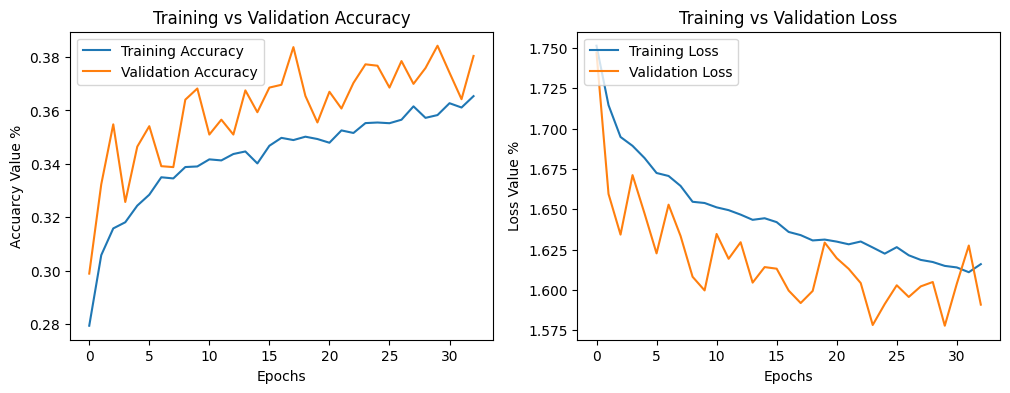

In [ ]:
#Model3
plot_acc(history2)

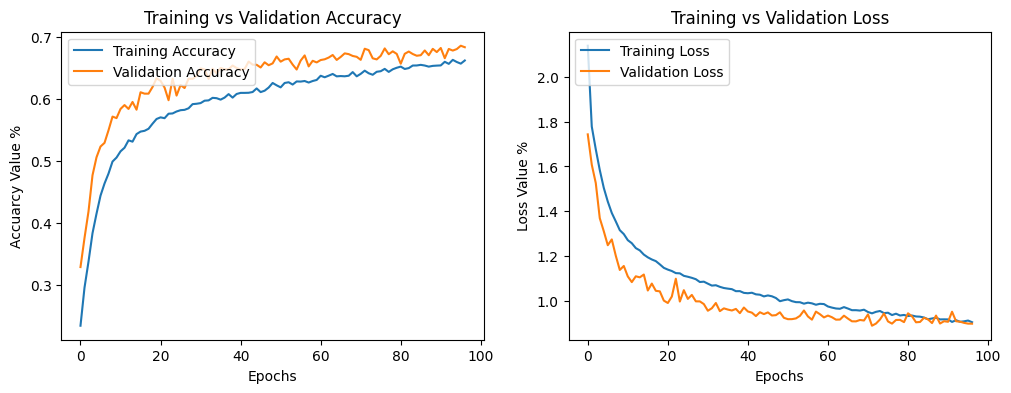

In [ ]:
#Model4
plot_acc(history3)

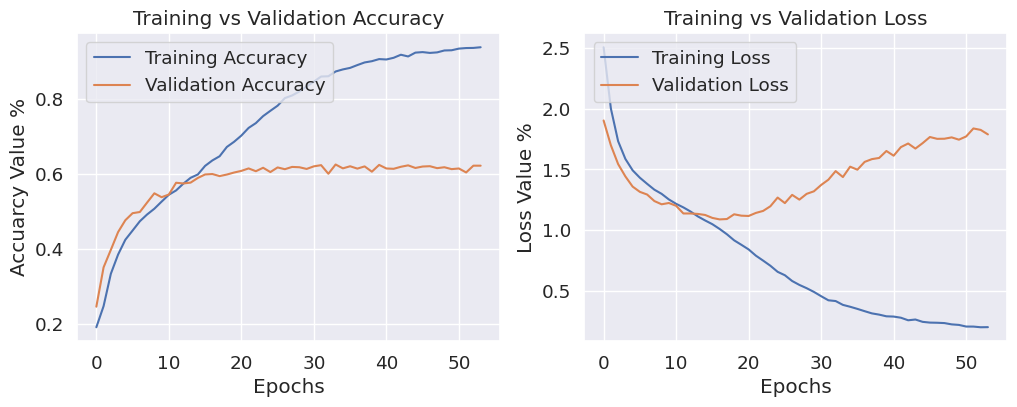

In [38]:
#Modelx
plot_acc(history4)

In [14]:
def loss_acc(model, train_batch, val_batch, test_batch):
  test_loss, test_acc = model.evaluate(test_batch) #, steps = test_batch.n // test_batch.batch_size
  train_loss, train_acc = model.evaluate(train_batch)
  val_loss, val_acc   = model.evaluate(val_batch)
  return (test_loss, test_acc), (train_loss, train_acc), (val_loss, val_acc)

In [86]:
models = [model1, model2, model3, model4]
for i, model in enumerate(models):
  if (i+1 == 2):
    test, train, validation = loss_acc(model, train_batch1, val_batch1, test_batch1)
  else:
    test, train, validation = loss_acc(model, train_batch, val_batch, test_batch)
  print(f"Test Loss for model {i+1}: {test[0]:.3%} , Test Accuracy: {test[1]:.3%}")
  print(f"Train Loss for model {i+1}: {train[0]: .3%} , Train Accuracy: {train[1]: .3%}")
  print(f"Validation Loss for model {i+1}: {validation[0]:.3%} , Validation Accuracy: {validation[1]:.3%}")
  print("-"*60)

90/90 [==============================] - 3s 31ms/step - loss: 0.9605 - accuracy: 0.6663
Test Loss for model 1: 96.911% , Test Accuracy: 66.453%
Train Loss for model 1:  41.427% , Train Accuracy:  86.725%
Validation Loss for model 1: 96.053% , Validation Accuracy: 66.626%
------------------------------------------------------------
90/90 [==============================] - 3s 35ms/step - loss: 1.5435 - accuracy: 0.4147
Test Loss for model 2: 152.073% , Test Accuracy: 42.143%
Train Loss for model 2:  122.975% , Train Accuracy:  53.714%
Validation Loss for model 2: 154.348% , Validation Accuracy: 41.474%
------------------------------------------------------------
90/90 [==============================] - 3s 28ms/step - loss: 1.0903 - accuracy: 0.6969
Test Loss for model 3: 112.211% , Test Accuracy: 69.072%
Train Loss for model 3:  15.905% , Train Accuracy:  94.976%
Validation Loss for model 3: 109.027% , Validation Accuracy: 69.692%
---------------------------------------------------------

model 2 (of the pretrained vgg19 model) has the worst loss and accuracy, so we will not continue our test with it

### Manual Testing

In [19]:
from tensorflow.keras.utils import img_to_array, load_img

labels_dict = test_batch.class_indices
"""
  returns: a dictionary where the key is the label (emotion), and value is the mapped value (from 0 to 6 indicating each emotion)
"""
labels_code = {v : k for k, v in labels_dict.items()}
"""
  Making the key of labels_dict the value of the labels_code
  & the value of labels_dict the key of labels_code

  returns: a dictionary where each integer number from 0 to 6 (the key) represent a label "emotion" which is the value.

"""

def test_images(model, img_path, labels_code):

  img = load_img(img_path, target_size = (48, 48),
                 color_mode = 'grayscale')

  i = img_to_array(img) #converting image to array
  input_arr = np.array([i])

  pred = np.argmax(model.predict(input_arr)) #get the highest probability

  print(f" the person is {labels_code[pred]}")

  # to display the original input image
  img = cv2.imread(img_path, 0)
  plt.imshow(img, cmap='gray')
  plt.title(f"Image is of a/an {labels_code[pred]} person") #displaying the model prediction above the image
  plt.show()

#I'll use this function at the end to compare the performance of each model on the same image

### Confusion Matrix

In [85]:
import pandas as pd
from sklearn.metrics import confusion_matrix , classification_report
import seaborn as sns

def predict_test(model, test_batch):
  preds = model.predict(test_batch)
  y_preds = np.argmax(preds , axis = 1 )
  y_test = np.array(test_batch.labels)
  return y_test, y_preds

def conf_matrix (model, test_batch, labels_dict):
  y_test, y_preds = predict_test(model, test_batch)
  cm_data = confusion_matrix(y_test , y_preds)
  cm = pd.DataFrame(cm_data, columns=labels_dict.keys(), index = labels_dict.keys())
  cm.index.name = 'Actual'
  cm.columns.name = 'Predicted'

  fig, ax = plt.subplots (figsize=(12, 8))
  plt.title('Confusion Matrix', fontsize = 20)
  sns.set(font_scale=1.2)
  ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

113/113 [==============================] - 2s 21ms/step


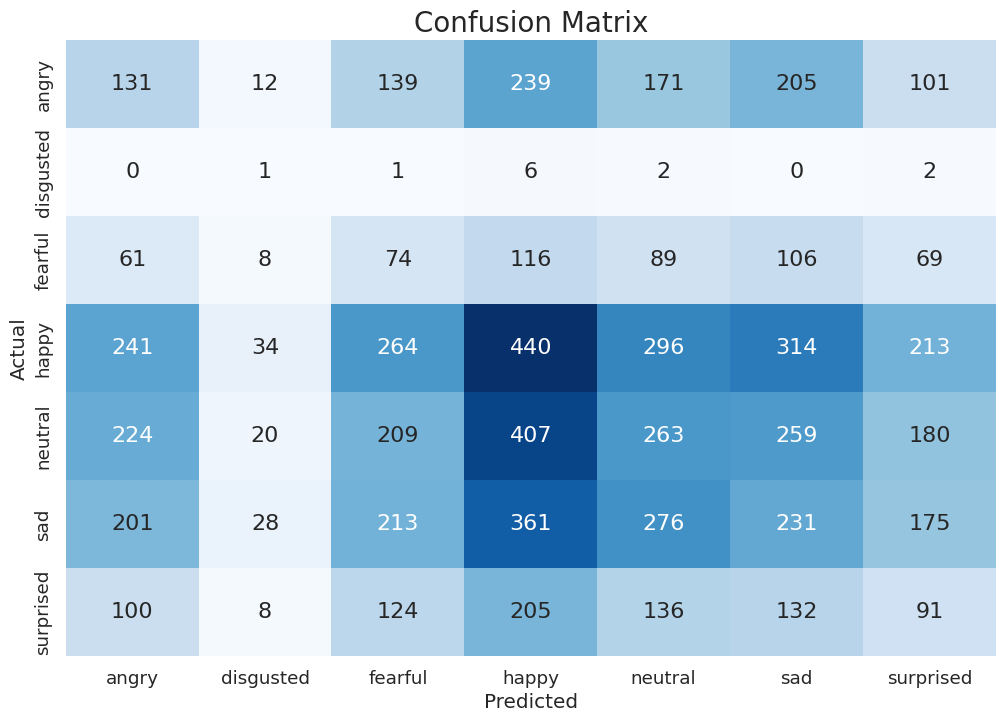

In [ ]:
conf_matrix(model1, test_batch, labels_dict)

113/113 [==============================] - 5s 43ms/step


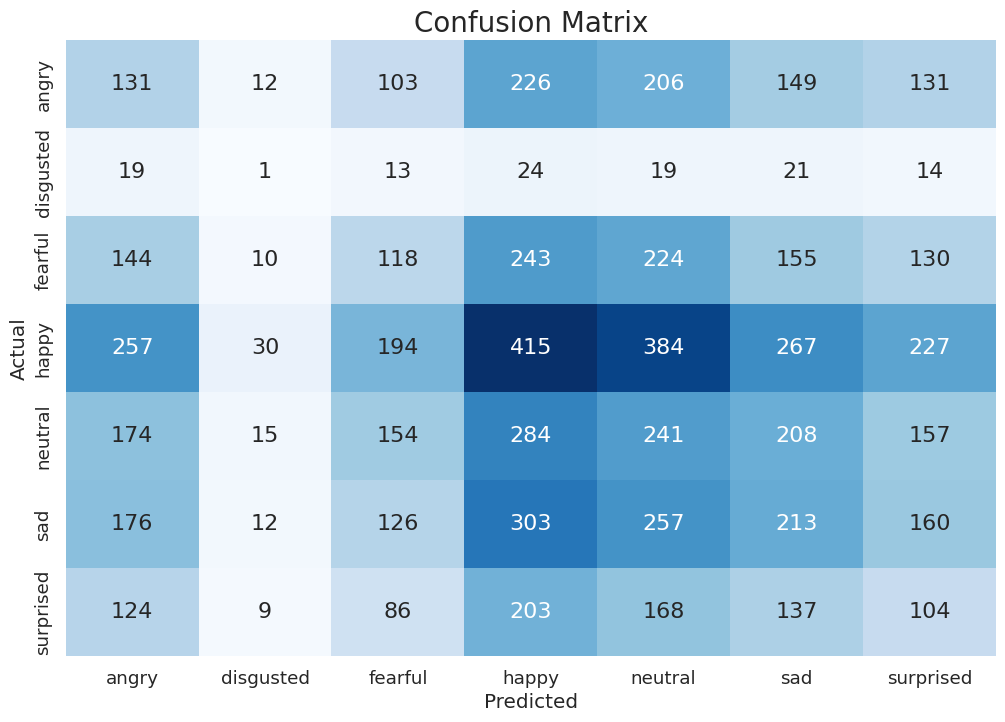

In [32]:
conf_matrix(model2, test_batch, labels_dict)

113/113 [==============================] - 3s 22ms/step


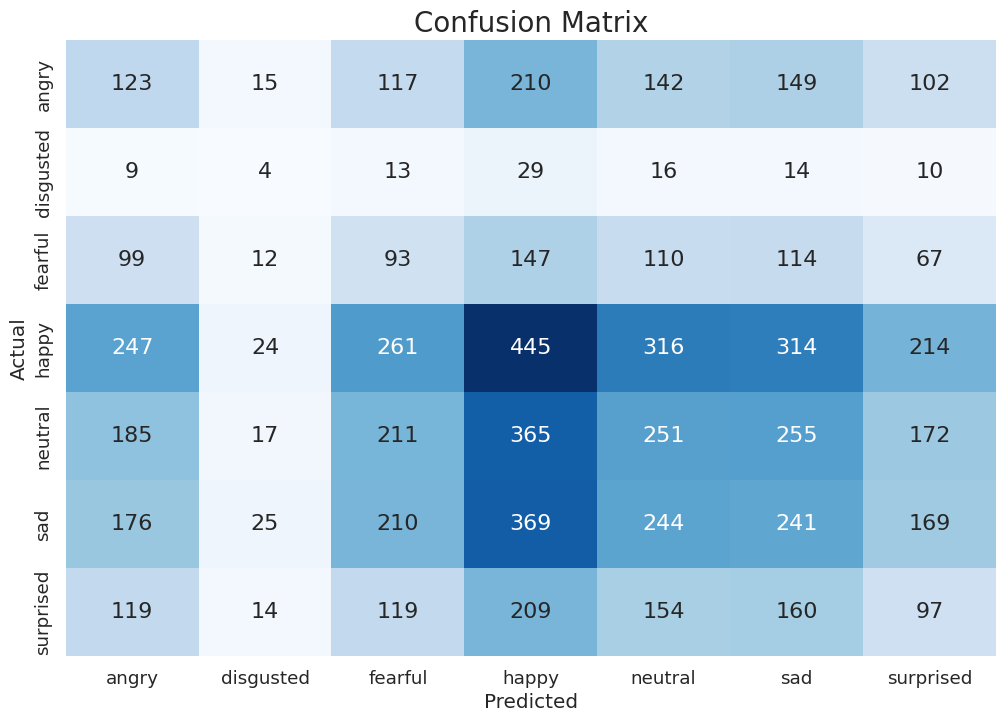

In [ ]:
conf_matrix(model3, test_batch, labels_dict)

113/113 [==============================] - 3s 27ms/step


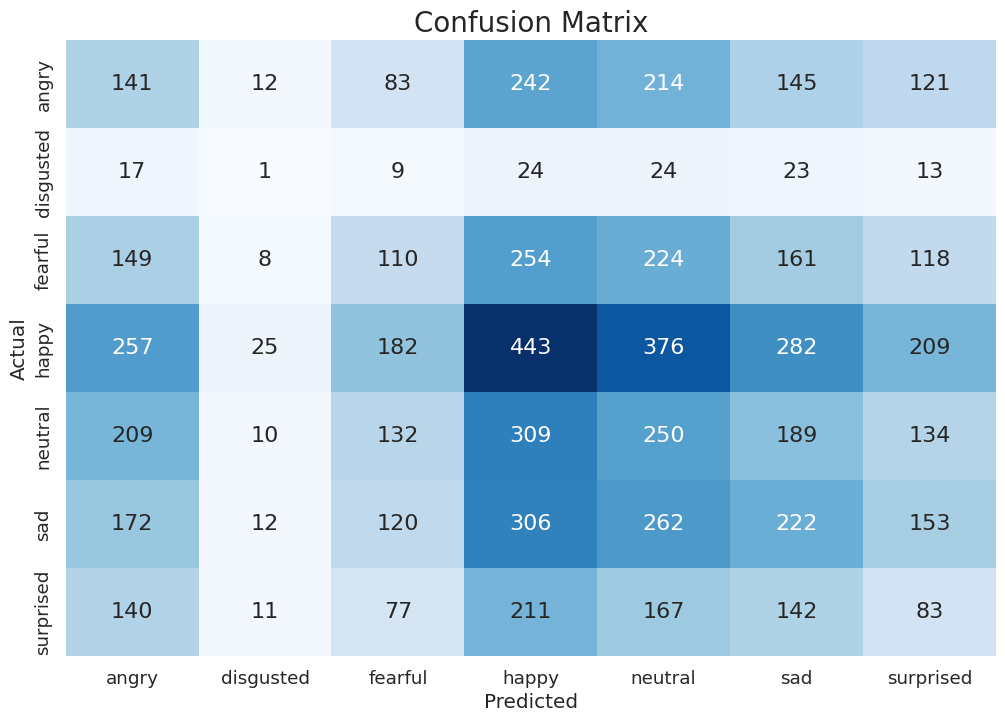

In [ ]:
conf_matrix(model4, test_batch, labels_dict)

## Testing the performance of each model

Model: 1
1/1 [==============================] - 0s 106ms/step
 the person is angry


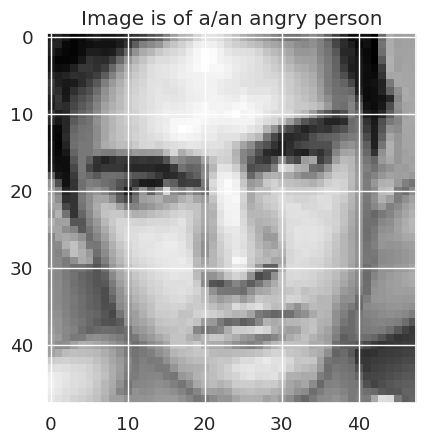

Model: 3
1/1 [==============================] - 0s 20ms/step
 the person is sad


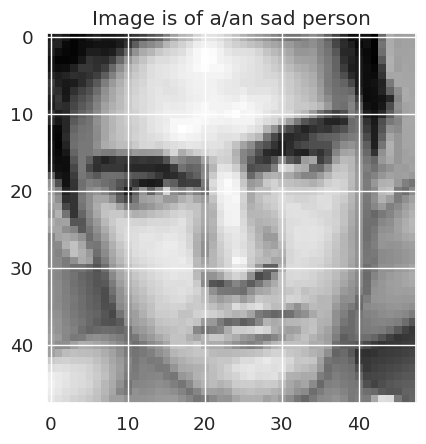

Model: 4
1/1 [==============================] - 0s 30ms/step
 the person is surprised


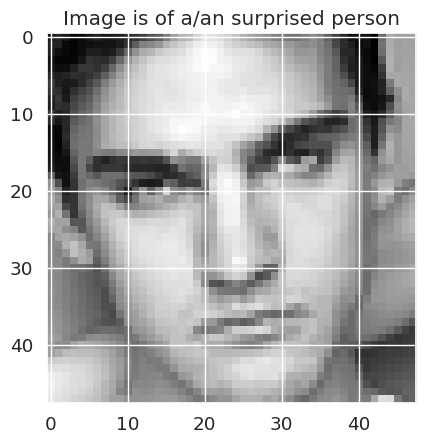

In [53]:
models = [model1, model3, model4]
for i, model in enumerate(models):
  img_path = '/content/EmotionDataset/test/angry/im10.png'
  if i == 0:
    print(f"Model: {i + 1}")
  else:
    print(f"Model: {i + 2}")
  test_images(model, img_path, labels_code)

Model: 1
1/1 [==============================] - 0s 19ms/step
 the person is happy


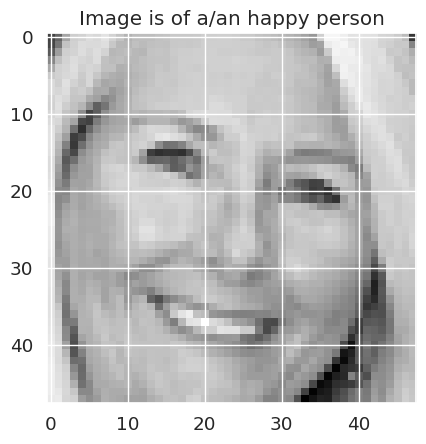

Model: 3
1/1 [==============================] - 0s 39ms/step
 the person is sad


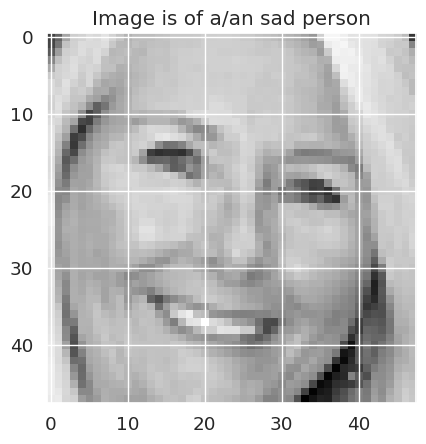

Model: 4
1/1 [==============================] - 0s 59ms/step
 the person is angry


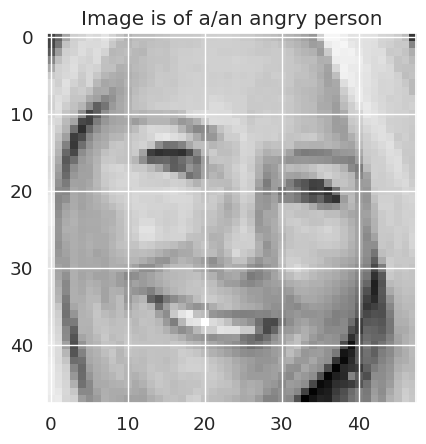

In [54]:
for i, model in enumerate(models):
  img_path = '/content/EmotionDataset/test/happy/im1003.png'
  if i == 0:
    print(f"Model: {i + 1}")
  else:
    print(f"Model: {i + 2}")
  test_images(model, img_path, labels_code)

Model: 1
1/1 [==============================] - 0s 31ms/step
 the person is angry


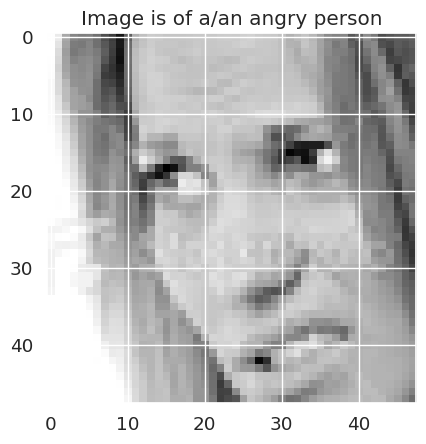

Model: 3
1/1 [==============================] - 0s 40ms/step
 the person is sad


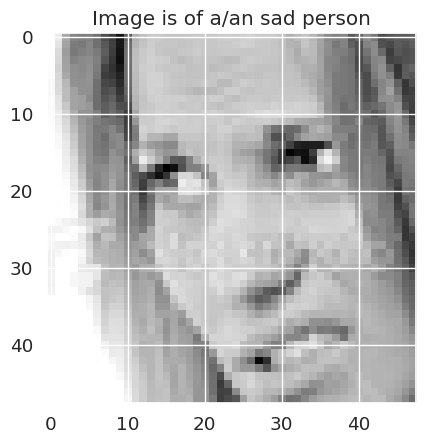

Model: 4
1/1 [==============================] - 0s 29ms/step
 the person is surprised


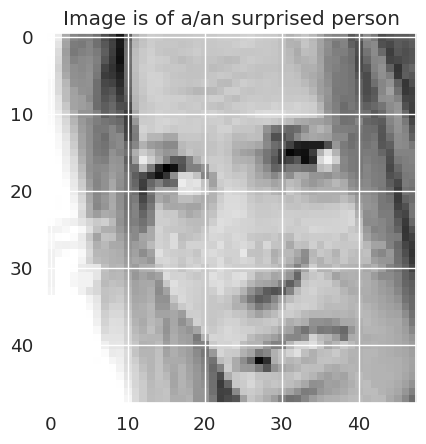

In [59]:
for i, model in enumerate(models):
  img_path = '/content/EmotionDataset/test/disgusted/im12.png'
  if i == 0:
    print(f"Model: {i + 1}")
  else:
    print(f"Model: {i + 2}")
  test_images(model, img_path, labels_code)

we can see that all models perform bad in the disgusted class because they haven't trained much on it due to its small number of images

Model: 1
1/1 [==============================] - 0s 34ms/step
 the person is fearful


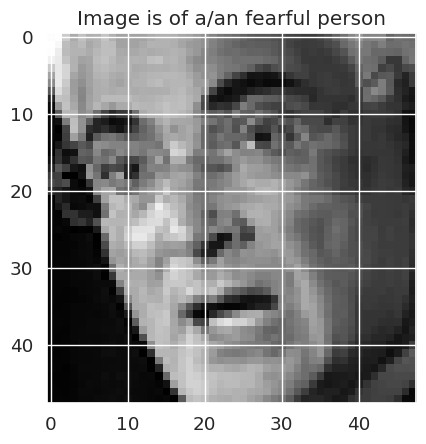

Model: 3
1/1 [==============================] - 0s 32ms/step
 the person is fearful


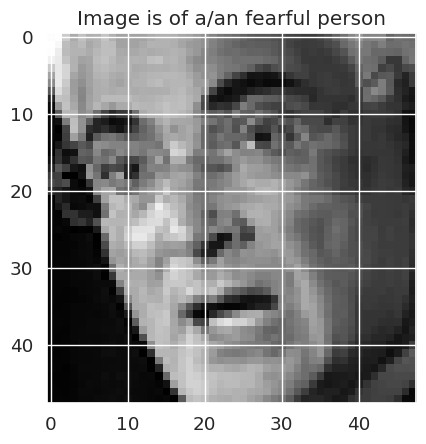

Model: 4
1/1 [==============================] - 0s 34ms/step
 the person is surprised


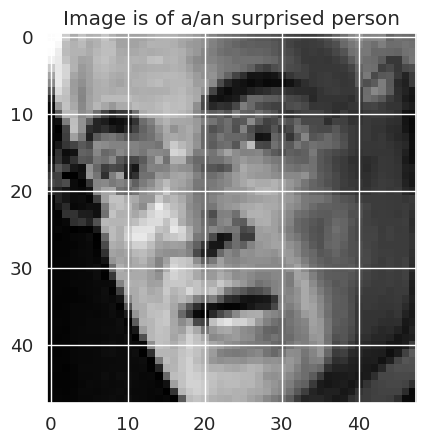

In [103]:
for i, model in enumerate(models):
  img_path = '/content/EmotionDataset/test/fearful/im202.png'
  if i == 0:
    print(f"Model: {i + 1}")
  else:
    print(f"Model: {i + 2}")
  test_images(model, img_path, labels_code)

Model 1 and Model 3 performed better than model 4 in fearful class

Model: 1
1/1 [==============================] - 0s 31ms/step
 the person is angry


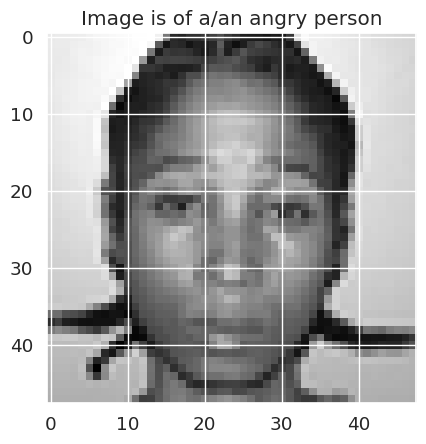

Model: 3
1/1 [==============================] - 0s 30ms/step
 the person is neutral


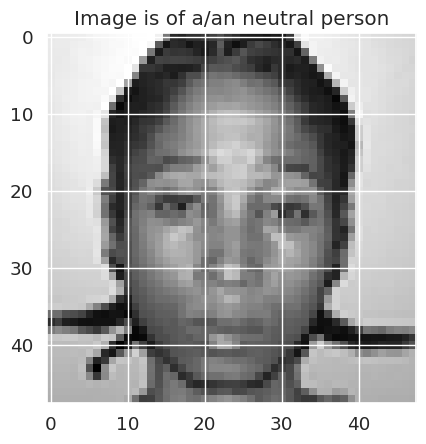

Model: 4
1/1 [==============================] - 0s 29ms/step
 the person is angry


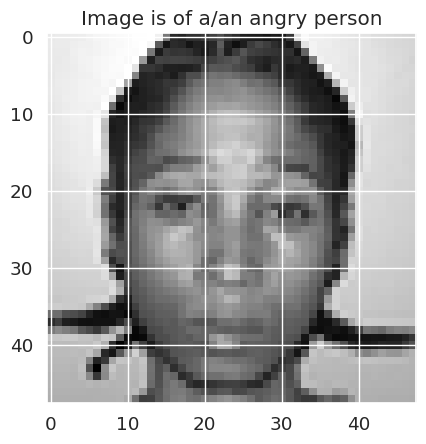

In [97]:
models = [model1, model2, model3, model4]
models.remove(model2)
for i, model in enumerate(models):
  img_path = '/content/EmotionDataset/test/neutral/im18.png'
  if i == 0:
    print(f"Model: {i + 1}")
  else:
    print(f"Model: {i + 2}")
  test_images(model, img_path, labels_code)

Model 3 performed better in neutral class

Model: 1
1/1 [==============================] - 0s 34ms/step
 the person is angry


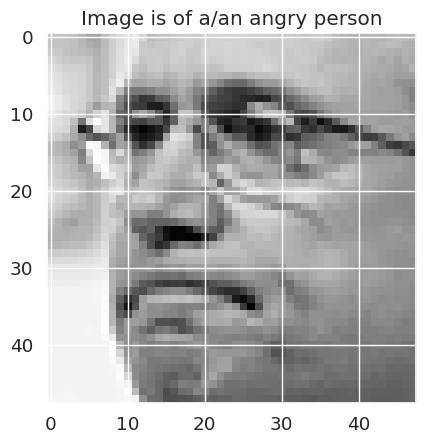

Model: 3
1/1 [==============================] - 0s 69ms/step
 the person is sad


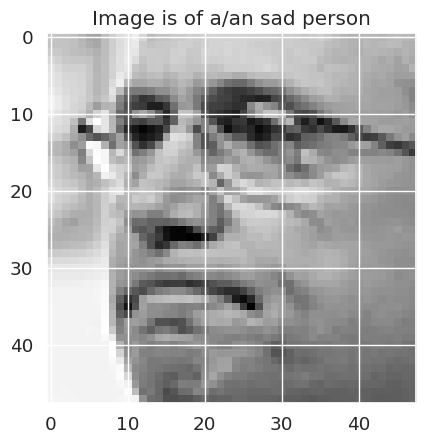

Model: 4
1/1 [==============================] - 0s 19ms/step
 the person is angry


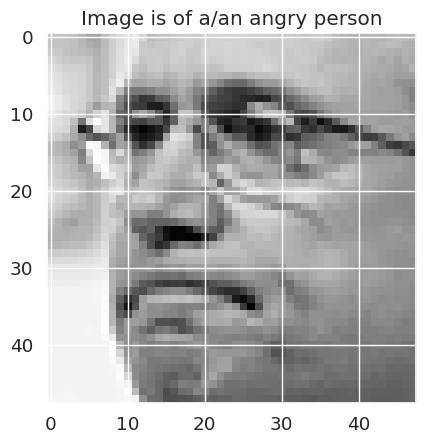

In [140]:
for i, model in enumerate(models):
  img_path = '/content/EmotionDataset/test/sad/im224.png'
  if i == 0:
    print(f"Model: {i + 1}")
  else:
    print(f"Model: {i + 2}")
  test_images(model, img_path, labels_code)

Model 3 performed better in sad class

Model: 1
1/1 [==============================] - 0s 32ms/step
 the person is surprised


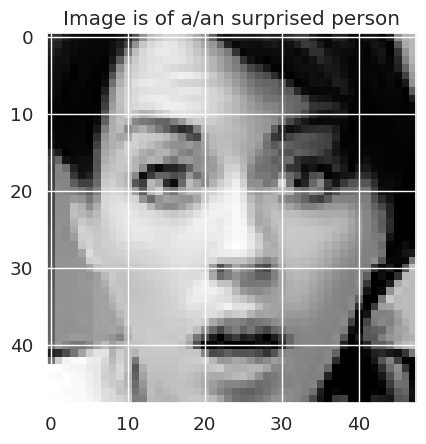

Model: 3
1/1 [==============================] - 0s 72ms/step
 the person is sad


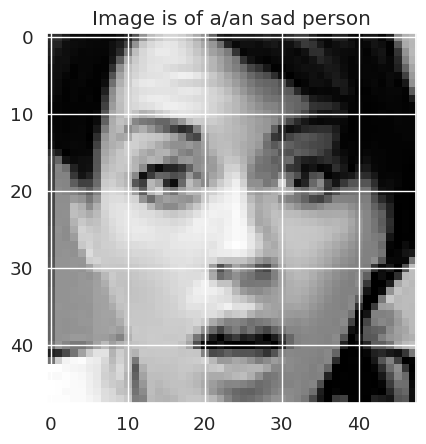

Model: 4
1/1 [==============================] - 0s 63ms/step
 the person is surprised


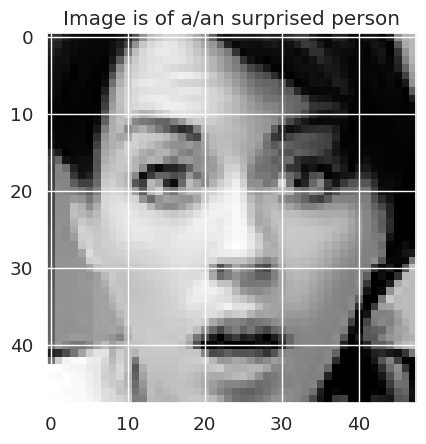

In [141]:
for i, model in enumerate(models):
  img_path = '/content/EmotionDataset/test/surprised/im111.png'
  if i == 0:
    print(f"Model: {i + 1}")
  else:
    print(f"Model: {i + 2}")
  test_images(model, img_path, labels_code)

Model 1 and 4 performed better in surprised class